In [1]:
import os
import re
import tensorflow as tf
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

tf.config.experimental.list_physical_devices('GPU')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prave\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
TRAIN_data = os.path.join('dataset', 'Train.csv')
TEST_data = os.path.join('dataset', 'Test.csv')
VAL_data = os.path.join('dataset', 'Valid.csv')
EMBEDDING_FILE =  os.path.join('dataset', 'glove', 'glove.6B.300d.txt')

In [3]:
train_data = pd.read_csv(TRAIN_data)
test_data = pd.read_csv(TEST_data)
val_data = pd.read_csv(VAL_data)

In [ ]:
lemmatizer = WordNetLemmatizer()
stp_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [ lemmatizer.lemmatize(word, 'v') for word in text]
    text = [word for word in text if word not in stp_words]
    text = " ".join(text)
    return text

In [5]:
MAX_LEN = 120
BUFFER_SIZE = 200
BATCH_SIZE = 128
VOCAB_SIZE = 30000
EMBEDDING_SIZE = 300

In [6]:
train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)
val_data['text'] = val_data['text'].apply(clean_text)

In [7]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['text'])

train_tokenized = tokenizer.texts_to_sequences(train_data['text'])
X_train = pad_sequences(train_tokenized, maxlen=MAX_LEN, padding='post')

val_tokenized = tokenizer.texts_to_sequences(val_data['text'])
X_val = pad_sequences(val_tokenized, maxlen=MAX_LEN, padding='post')

test_tokenized = tokenizer.texts_to_sequences(test_data['text'])
X_test = pad_sequences(test_tokenized, maxlen=MAX_LEN, padding='post')

In [8]:


Y_train = train_data.pop('label')
Y_val = val_data.pop('label')
Y_test = test_data.pop('label')

Y_train = np.expand_dims(Y_train, [1])
Y_val = np.expand_dims(Y_val, [1])
Y_test = np.expand_dims(Y_test, [1])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(512)


In [9]:
def get_glove_embeddings(file_name):
    embeddings_map = dict()
    with open(file_name,  encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddings = np.asarray(values[1:], dtype='float32')
            embeddings_map[word] = embeddings
    return embeddings_map

mapp = get_glove_embeddings(EMBEDDING_FILE)

In [10]:
def build_embeddings(vocab_size, tokenizer):
    match_counter = 0
    embeddings = np.zeros((vocab_size, EMBEDDING_SIZE))
    emb_map = get_glove_embeddings(EMBEDDING_FILE)
    for word, i in tokenizer.word_index.items():
        if word in emb_map:
            embeddings[i] = emb_map.get(word)
            match_counter += 1
    return embeddings, match_counter


In [11]:
embedding_weights, match_counter = build_embeddings(len(tokenizer.word_index)+1, tokenizer)

In [12]:
def create_basic_lstm_model(embedding_weights, input_shape=(MAX_LEN,)):
    """
    Bi-directional LSTM without attention
    """
    inp = tf.keras.layers.Input(shape=input_shape)
    embedding = tf.keras.layers.Embedding(
            len(tokenizer.word_index)+1,
            output_dim=300,
            weights=[embedding_weights],
            input_length=MAX_LEN
    )(inp)
    
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
    )(embedding)
    
    lstm2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, activation='tanh')
    )(lstm1)
    # max_pool = tf.keras.layers.GlobalMaxPooling1D()(lstm2)
    dropout = tf.keras.layers.Dropout(0.5)(lstm2)
    dense1 = tf.keras.layers.Dense(64, activation='relu')(dropout)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    
    model = tf.keras.Model(inputs=inp, outputs=output)
    return model
    

In [13]:
class BasicAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BasicAttention, self).__init__()
        
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        
        self.v = tf.keras.layers.Dense(1)
        
    def call(self, features, hidden_state):
        
        hidden_state_with_axis = tf.expand_dims(hidden_state, 1)
        scores = tf.nn.tanh(self.w1(features) + self.w2(hidden_state_with_axis))
        attention_weights = tf.nn.softmax(self.v(scores), axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights
        

In [14]:
def build_lstm_with_attention(embedding_weights, input_shape=(MAX_LEN,)):
    """
    Bi-directional LSTM with Attention
    """
    inp = tf.keras.layers.Input(shape=input_shape)
    embedding = tf.keras.layers.Embedding(
            len(tokenizer.word_index)+1,
            output_dim=300,
            weights=[embedding_weights],
            input_length=MAX_LEN
    )(inp)
    
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
    )(embedding)
    
    (lstm, forward_h, forward_c, backward_h, backward_d) = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, return_state=True)
    )(lstm1)
    
    hidden_state = tf.keras.layers.Concatenate()([forward_h, backward_h])
    context_vector, attention_weights = BasicAttention(16)(lstm, hidden_state)
    
    dense1 = tf.keras.layers.Dense(64, activation='relu')(context_vector)
    dropout = tf.keras.layers.Dropout(0.5)(dense1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)
    
    model = tf.keras.Model(inputs=inp, outputs=output)
    return model
    

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, num_heads, dims):
        super(MultiHeadAttention, self).__init__()
        
        self.num_heads = num_heads
        self.dims = dims
        
        self.depth = self.dims // self.num_heads
        
        self.kw = tf.keras.layers.Dense(self.dims)
        self.qw = tf.keras.layers.Dense(self.dims)
        self.vw = tf.keras.layers.Dense(self.dims)
        
        self.dense = tf.keras.layers.Dense(self.dims)
        
    def split_heads(self, inputs):
        batch_size = tf.shape(inputs)[0]
        reshaped = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
        transposed = tf.transpose(reshaped, perm=[0, 2, 1, 3])
        return transposed
        
    def call(self, k, v, q):
        k = self.kw(k)
        q = self.qw(q)
        v = self.vw(v)
        
        # multi head
        k = self.split_heads(k)
        q = self.split_heads(q)
        v = self.split_heads(v)
        
        ## self attention
        
        mult_kq = tf.matmul(q, k, transpose_b=True)
        normalized_mult = mult_kq / tf.cast(self.depth, tf.float32)
        attention_weights = tf.nn.softmax(normalized_mult, axis=-1)
        output = tf.matmul(attention_weights, v)

        scaled_attention = tf.transpose(output, perm=[0, 2, 1, 3])
        
        batch_size = tf.shape(q)[0]
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.dims))
        output = self.dense(concat_attention)
        
        return output
        
    

In [16]:
temp_mha = MultiHeadAttention(dims=100, num_heads=4)
y = tf.random.uniform((1, 10, 100))  # (batch_size, encoder_sequence_length, d_model)
out = temp_mha(y, y, y)
out.shape

TensorShape([1, 10, 100])

In [17]:
class TokenAndPositionEmbeddings(tf.keras.layers.Layer):
    
    def __init__(self, maxlen, emb_dim, vocab_size, weights):
        super(TokenAndPositionEmbeddings, self).__init__()
        
        self.embds = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, weights=[weights])
        self.pos_embs = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=emb_dim)
    
    def call(self, inputs):
        max_len = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_embs(positions)
        embeddings = self.embds(inputs)
        return embeddings + positions

In [18]:
class Transformer(tf.keras.layers.Layer):
    """
    Transfomer Encoder with Multi-head attention (6 heads)
    """
    def __init__(self, dims, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()
        
        self.mha = MultiHeadAttention(num_heads, dims)
        self.ff = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(dims)
        ])
        
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, inputs, training):
        attention_output = self.mha(inputs, inputs, inputs)
        attention_output = self.dropout1(attention_output, training=training)
        layer_norm1 = self.layer_norm1(inputs + attention_output)
        
        ff_output = self.ff(layer_norm1)
        ff_output = self.dropout2(ff_output, training=training)
        return self.layer_norm2(layer_norm1 + ff_output)
        

In [19]:
def build_multi_head_attention(input_shape=(MAX_LEN,)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = TokenAndPositionEmbeddings(MAX_LEN, 300, len(tokenizer.word_index)+1, embedding_weights)(inputs)
    x = Transformer(300, num_heads=6, ff_dim=512)(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1, name="drop1")(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1, name="drop2")(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
    

In [20]:
model = build_multi_head_attention(input_shape=(MAX_LEN,))
model.summary()

loss_fn = tf.keras.losses.BinaryCrossentropy()
bce_metric = tf.keras.metrics.BinaryAccuracy()
optimizer = tf.keras.optimizers.Adam()

bce_val_metric = tf.keras.metrics.BinaryAccuracy()

pbar = tf.keras.utils.Progbar(len(train_dataset))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

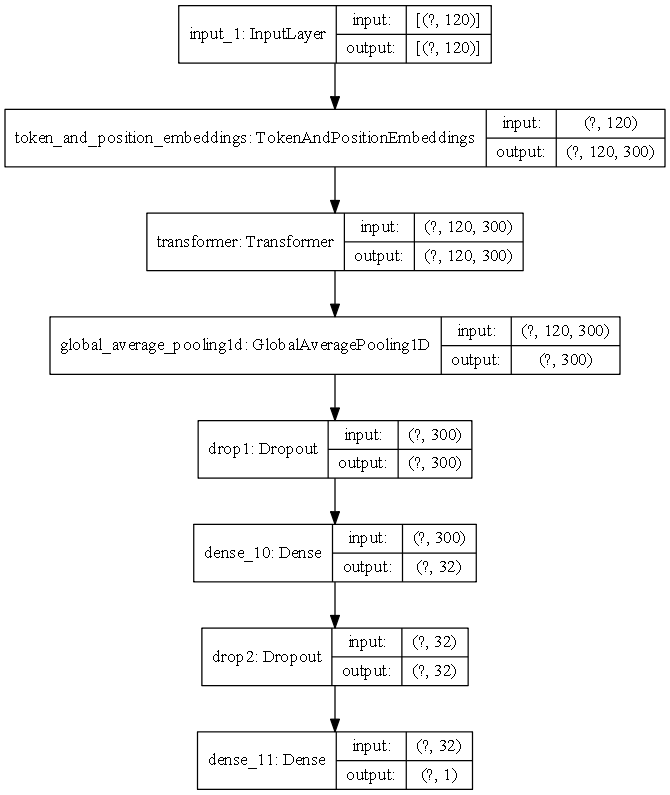

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [22]:
@tf.function
def train_step(X_train, Y_train, model):
    with tf.GradientTape() as tape:
        predictions = model(X_train, training=True)
        loss = loss_fn(Y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    bce_metric.update_state(Y_train, predictions)
    return loss

@tf.function    
def val_step(X_val, Y_val, model):
    predictions = model(X_val, training=False)
    loss = loss_fn(Y_val, predictions)
    bce_val_metric.update_state(Y_val, predictions)
    return loss

In [23]:
EPOCHS = 8

def train_loop():
    print('Starting training...')
    losses = []
    acc = []
    for e in range(EPOCHS):

        for j, (X_train, Y_train) in enumerate(train_dataset):
            loss = train_step(X_train, Y_train, model)
            pbar.update(j+1)
        
        losses.append(loss)
        acc.append(bce_metric.result())
        
        print(f"Training -- {e + 1} : loss:{loss}  accuracy:{bce_metric.result()}")
        bce_metric.reset_states()
            
        if e % 5 == 0:
            model.save('weights_imdb')
        
        for k, (X_val, Y_val) in enumerate(val_dataset):
            val_loss = val_step(X_val, Y_val, model)
            
        print(f"Validation --{e+1} loss:{val_loss} accuracy:{bce_val_metric.result()}")
        bce_val_metric.reset_states()
                
    model.save('base_lstm_model')

In [24]:
test_bce_metric = tf.keras.metrics.BinaryAccuracy()

def evaluate():
    for i, (X_test, Y_test) in enumerate(test_dataset):
        predictions = model.predict(X_test)
        test_bce_metric.update_state(Y_test, predictions)
        print(f"Evalucation accurcy:{test_bce_metric.result()}")
        test_bce_metric.reset_states()

In [25]:
train_loop()

Starting training...
313/313 [==============================] - 95s 305ms/step
Training -- 1 : loss:0.25902238488197327  accuracy:0.8345999717712402
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: weights_imdb\assets
Validation --1 loss:0.10217989236116409 accuracy:0.883400022983551
313/313 [==============================] - 194s 621ms/step
Training -- 2 : loss:0.350799024105072  accuracy:0.9156500101089478
Validation --2 loss:0.11109419912099838 accuracy:0.8934000134468079
313/313 [==============================] - 286s 913ms/step
Training -- 3 : loss:0.03762210160493851  accuracy:0.9490500092506409
Validation --3 loss:0.13166017830371857 accuracy:0.8640000224113464
313/313 [==============================] - 379s 1s/step
Training -- 4 : loss:0.07200001925230026  accur

In [26]:
# model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')
# model.fit(X_train,Y_train, epochs=10, steps_per_epoch=625, validation_data=(X_val, Y_val))

In [27]:
evaluate()

Evalucation accurcy:0.859375
Evalucation accurcy:0.84765625
Evalucation accurcy:0.845703125
Evalucation accurcy:0.8671875
Evalucation accurcy:0.880859375
Evalucation accurcy:0.87890625
Evalucation accurcy:0.865234375
Evalucation accurcy:0.814453125
Evalucation accurcy:0.884765625
Evalucation accurcy:0.8673469424247742


In [28]:
sample = [
    "very bad movie",
    "great movie, loved the acting and the plot, was enjoyable"
]

test_sequences = tokenizer.texts_to_sequences(sample)
test_sequences = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post')
model.predict(test_sequences)

array([[0.05193231],
       [0.9515971 ]], dtype=float32)

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 100

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\prave\anaconda3\envs\tf_gpu\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 100